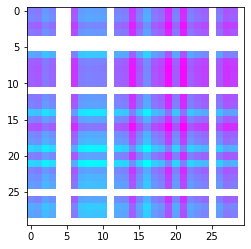

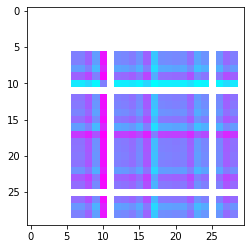

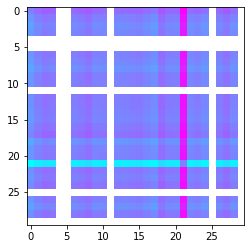

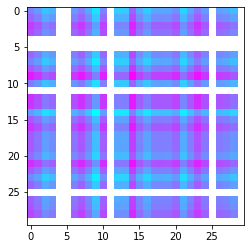

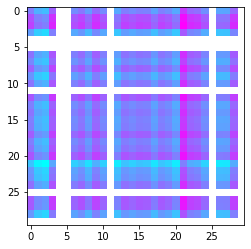

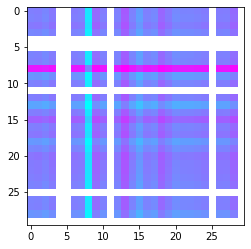

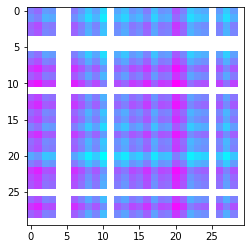

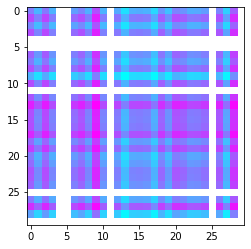

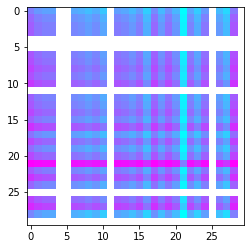

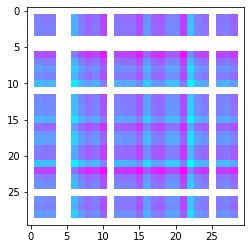

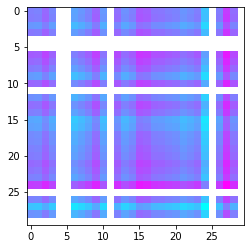

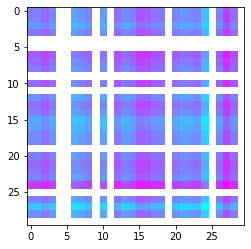

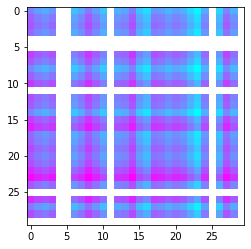

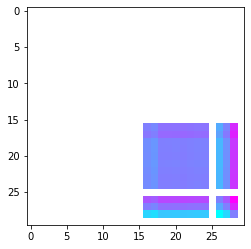

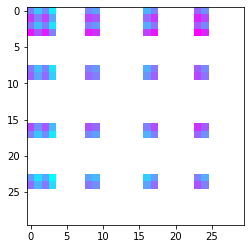

In [51]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_30.npy")
#GADF = np.nan_to_num(GADF)

for i in range(15):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

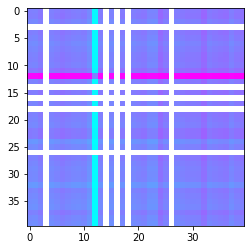

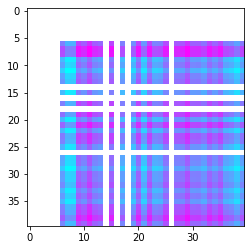

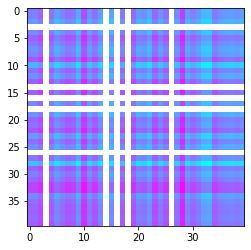

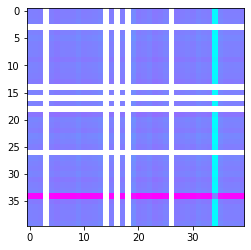

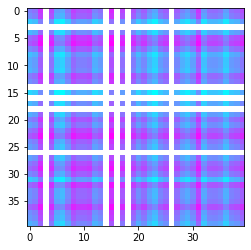

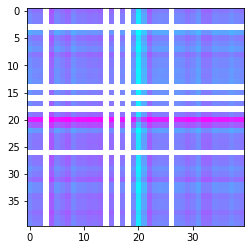

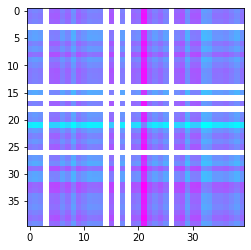

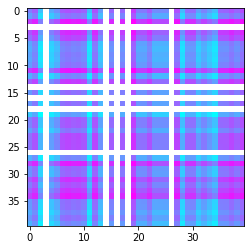

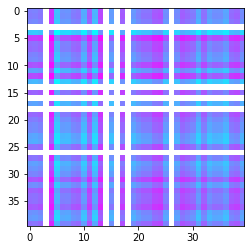

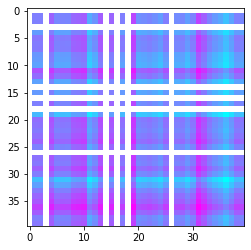

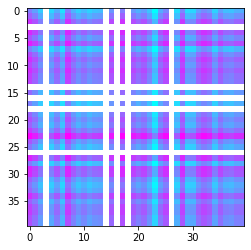

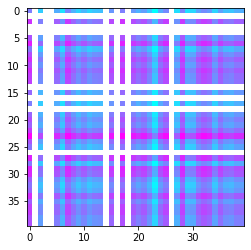

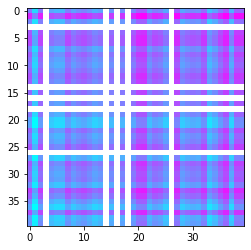

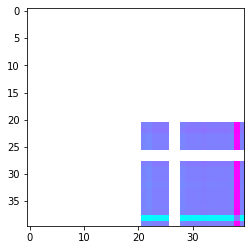

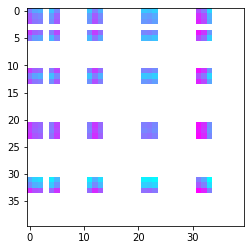

In [53]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_40.npy")

for i in range(15):
    plt.imshow(GADF[i], cmap='cool')

    plt.show()

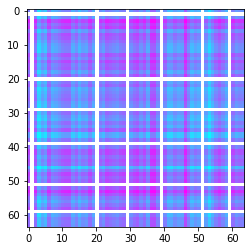

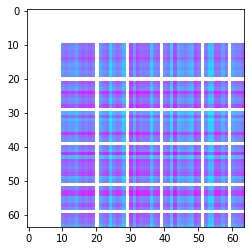

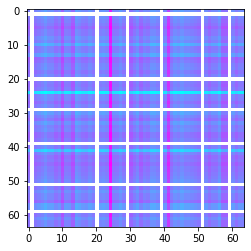

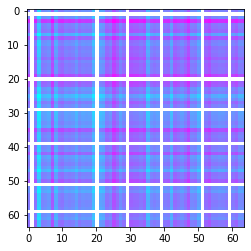

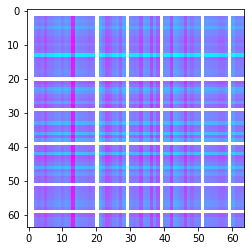

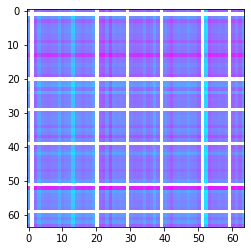

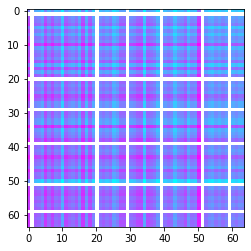

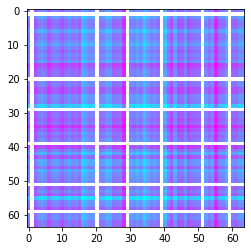

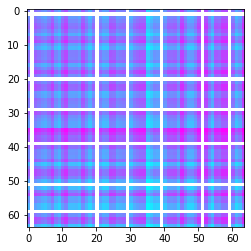

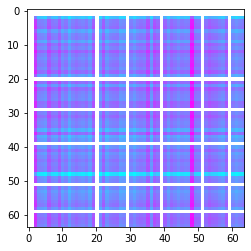

In [54]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_64.npy")

for i in range(10):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

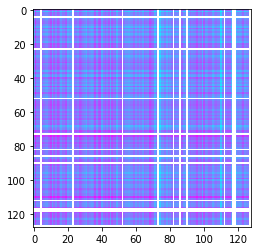

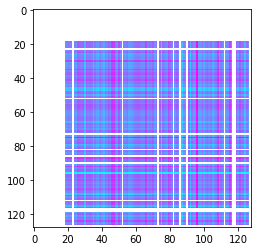

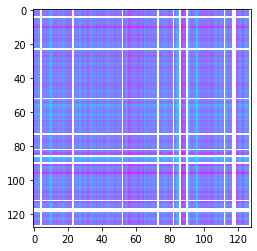

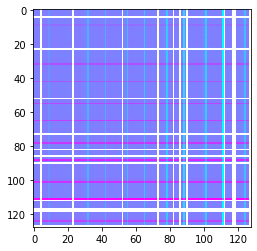

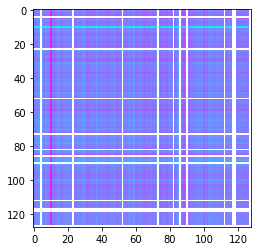

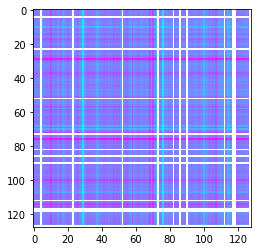

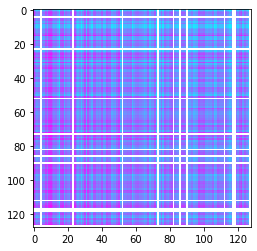

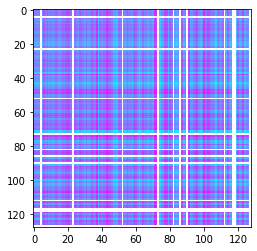

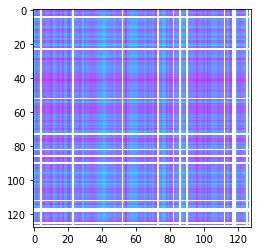

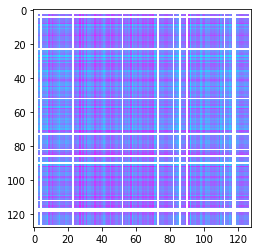

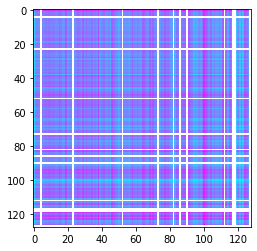

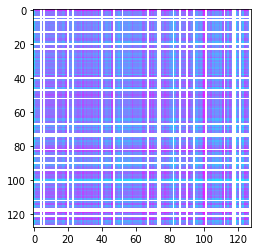

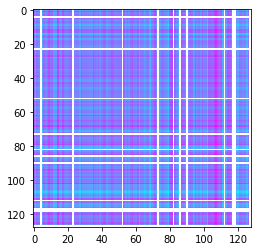

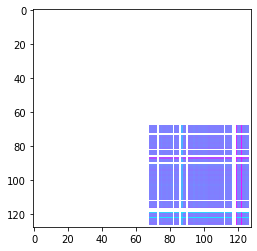

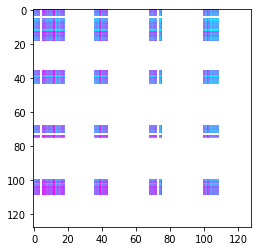

In [9]:
import numpy as np
import matplotlib.pyplot as plt
GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_128.npy")

for i in range(15):
    plt.imshow(GADF[i], cmap='cool')
    plt.show()

In [27]:
SIZE = 64

In [5]:
!ls /work/work_teamEXOPLANET/MTF_margarita/no_invertidos/

MTF_u10_d10.npy  MTF_u15_d20.npy  MTF_u32_d32.npy  MTF_u64_d16.npy
MTF_u10_d15.npy  MTF_u15_d30.npy  MTF_u32_d64.npy  MTF_u64_d32.npy
MTF_u10_d20.npy  MTF_u16_d16.npy  MTF_u5_d10.npy   MTF_u64_d64.npy
MTF_u10_d30.npy  MTF_u16_d32.npy  MTF_u5_d15.npy
MTF_u15_d10.npy  MTF_u16_d64.npy  MTF_u5_d20.npy
MTF_u15_d15.npy  MTF_u32_d16.npy  MTF_u5_d30.npy


In [28]:
import numpy as np
import pandas as pd
def prepare_lc_GAF(fluxs): #rango entre -1 y 1
    max_f = np.nanmax(fluxs)
    min_f = np.nanmin(fluxs)
    return (2*fluxs- max_f - min_f)/(max_f-min_f)


def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    MTF_o = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(SIZE/2,SIZE/2))  
    MTF_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u%d_d%d.npy'%(SIZE/2,SIZE/2))  
    #T_o = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/time_channel_%d.npy'%SIZE)  
    GADF = np.load("/work/work_teamEXOPLANET/GAF/GADF_%d.npy"%SIZE) #tambien se puede hacer inversa (trans)
    GASF = np.load("/work/work_teamEXOPLANET/GAF/GASF_%d.npy"%SIZE)
    
    #pro-process GAF : scale > fill nan
    #GADF = prepare_lc_GAF(GADF)  #scale -1 y 1
    #GASF = prepare_lc_GAF(GASF)  #scale -1 y 1
    #fill nan with??
    GADF = np.nan_to_num(GADF)
    GASF = np.nan_to_num(GASF)

    x_all = []
    for i in range(MTF_o.shape[0]):
        combined_image = np.dstack((GADF[i],GASF[i],MTF_o[i]))
        x_all.append(combined_image)
    x_all = np.asarray(x_all)
    print("shape:",x_all.shape)

    fold ="../../KOI_Data/"
    df_sets = pd.read_csv(fold+"/koi_sets.csv") 
    mask_train = (df_sets["Set"] == "Train").values
    mask_test = (df_sets["Set"] == "Test").values

    df_meta = pd.read_csv(fold+"/koi_metadata.csv")
    df_meta_train = df_meta[mask_train]
    df_meta_test = df_meta[mask_test]
    y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
    y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_val, counts_val = np.unique(y_val, return_counts=True)

    x_train = x_all[mask_train]
    x_val = x_all[mask_test]
    
    print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
    print ("Objetos de validación:",x_val.shape,y_val.shape)

    return x_train, y_train, x_val, y_val

In [29]:
x_train, y_train, x_val, y_val = data()

shape: (8054, 64, 64, 3)
Objetos de entrenamiento: (4339, 64, 64, 3) (4339,)
Objetos de validación: (1918, 64, 64, 3) (1918,)


In [30]:
import keras, os, sys
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from sklearn.metrics import f1_score
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from utils import binary_focal_loss
from evaluation import calculate_metrics
keras.losses.binary_focal_loss_fixed = keras.losses.mse

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return 
    
def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    #if not focal:
    #    calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()

In [31]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    return model

In [32]:
model = define_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6272)            

In [ ]:
## algun gad por si solo?

In [ ]:
plt.imshow()

### GADF + GASF (128)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 13s 3ms/step - loss: 0.8291 - acc: 0.6056 - val_loss: 0.6583 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 13s 3ms/step - loss: 0.6249 - acc: 0.6453 - val_loss: 0.6511 - val_acc: 0.5668
 - val_f1: 0.496694 
Epoch 3/200
3905/3905 [==============================] - 12s 3ms/step - loss: 0.6014 - acc: 0.6494 - val_loss: 0.6317 - val_acc: 0.5691
 - val_f1: 0.494239 
Epoch 4/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.6005 - acc: 0.6497 - val_loss: 0.6341 - val_acc: 0.5668
 - val_f1: 0.496694 
Epoch 5/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5758 - acc: 0.6633 - val_loss: 0.6145 - val_acc: 0.5737
 - val_f1: 0.501710 
Epoch 6/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5719 - acc: 0.6586 - val_loss: 0.6069 - val_acc: 0.5714
 - val_f1: 0.509694 
Epoch 7/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5589 - acc: 0.6689 - val_loss: 0.6030 - val_acc: 0.5806
 - val_f1: 0.522015 
Epoch 8/200
3905/3905 [==============

 - val_f1: 0.589495 
Epoch 54/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.1168 - acc: 0.9657 - val_loss: 1.5922 - val_acc: 0.5945
 - val_f1: 0.574510 
Epoch 55/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.1078 - acc: 0.9608 - val_loss: 1.6731 - val_acc: 0.6014
 - val_f1: 0.576600 
Epoch 56/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0933 - acc: 0.9729 - val_loss: 1.7508 - val_acc: 0.5968
 - val_f1: 0.572707 
Epoch 57/200
3905/3905 [==============================] - 10s 3ms/step - loss: 0.1065 - acc: 0.9634 - val_loss: 1.5575 - val_acc: 0.6037
 - val_f1: 0.583298 
Epoch 58/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.1017 - acc: 0.9665 - val_loss: 1.6276 - val_acc: 0.6014
 - val_f1: 0.585482 
Epoch 59/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0952 - acc: 0.9672 - val_loss: 1.6613 - val_acc: 0.6129
 - val_f1: 0.585284 
Epoch 60/200
3905/3905 [=======

 - val_f1: 0.596306 
Epoch 106/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0510 - acc: 0.9839 - val_loss: 2.2223 - val_acc: 0.6290
 - val_f1: 0.614235 
Epoch 107/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0564 - acc: 0.9821 - val_loss: 2.4113 - val_acc: 0.6083
 - val_f1: 0.587249 
Epoch 108/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0499 - acc: 0.9859 - val_loss: 2.2526 - val_acc: 0.6106
 - val_f1: 0.595816 
Epoch 109/200
3905/3905 [==============================] - 12s 3ms/step - loss: 0.0494 - acc: 0.9859 - val_loss: 2.4645 - val_acc: 0.6037
 - val_f1: 0.575410 
Epoch 110/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0477 - acc: 0.9872 - val_loss: 2.3709 - val_acc: 0.6129
 - val_f1: 0.592989 
Epoch 111/200
3905/3905 [==============================] - 12s 3ms/step - loss: 0.0531 - acc: 0.9826 - val_loss: 2.3878 - val_acc: 0.6014
 - val_f1: 0.579502 
Epoch 112/200
3905/3905 [

3905/3905 [==============================] - 11s 3ms/step - loss: 0.0359 - acc: 0.9895 - val_loss: 2.6142 - val_acc: 0.6106
 - val_f1: 0.597254 
Epoch 158/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0460 - acc: 0.9880 - val_loss: 2.6286 - val_acc: 0.6129
 - val_f1: 0.594690 
Epoch 159/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0320 - acc: 0.9905 - val_loss: 2.9651 - val_acc: 0.5899
 - val_f1: 0.560599 
Epoch 160/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0313 - acc: 0.9910 - val_loss: 2.8825 - val_acc: 0.6175
 - val_f1: 0.596066 
Epoch 161/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0441 - acc: 0.9895 - val_loss: 2.5181 - val_acc: 0.6129
 - val_f1: 0.597838 
Epoch 162/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.0387 - acc: 0.9890 - val_loss: 2.9305 - val_acc: 0.6175
 - val_f1: 0.599515 
Epoch 163/200
3905/3905 [==============================] - 1

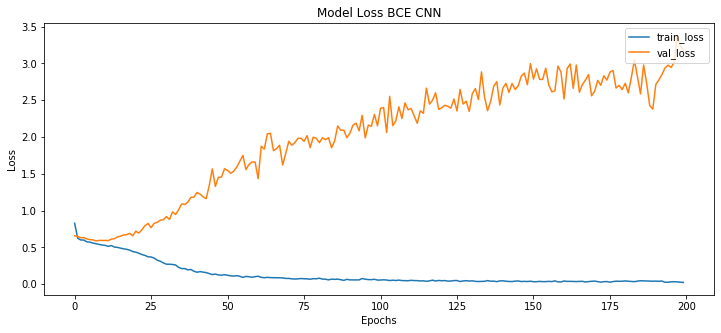

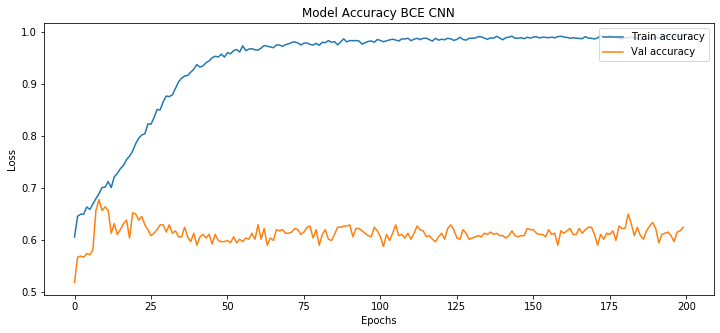

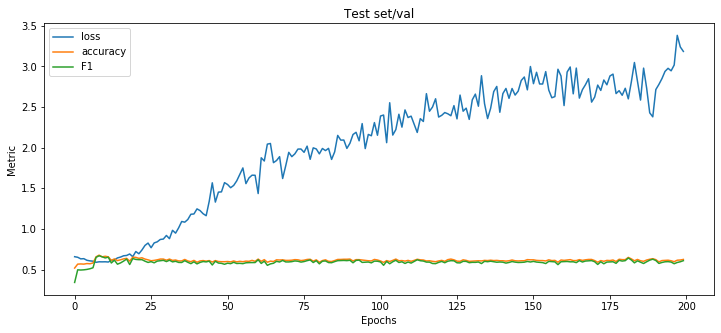

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.803410,0.642342,0.713904,0.672913,0.655319,0.665276
Confirmed,0.515744,0.707899,0.596734,0.672913,0.655319,0.665276


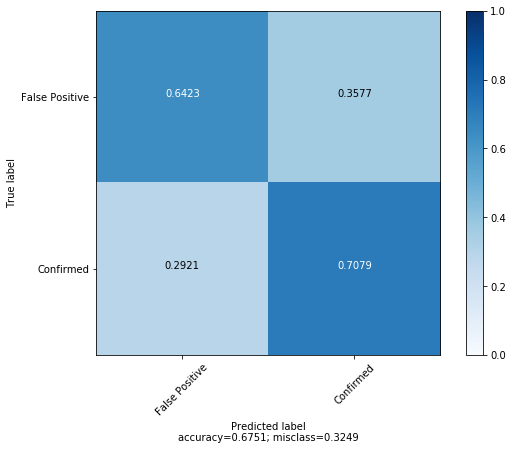

{'Precision raw': array([0.80341023, 0.51574376]),
 'Recall raw': array([0.64234162, 0.70789866]),
 'F1 raw': array([0.71390374, 0.59673367]),
 'F1 weighted': 0.672912543989429,
 'F1 macro': 0.6553187058286083,
 'F1 micro': 0.6652763295099061,
 'Confusion Matrix': array([[801, 446],
        [196, 475]])}

In [20]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 13s 3ms/step - loss: 26.0914 - acc: 0.5457 - val_loss: 9.8612 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 12s 3ms/step - loss: 9.8937 - acc: 0.6412 - val_loss: 9.7815 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 3/200
3905/3905 [==============================] - 12s 3ms/step - loss: 9.5636 - acc: 0.6415 - val_loss: 9.6873 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 4/200
3905/3905 [==============================] - 11s 3ms/step - loss: 9.4840 - acc: 0.6525 - val_loss: 9.5988 - val_acc: 0.5645
 - val_f1: 0.465235 
Epoch 5/200
3905/3905 [==============================] - 11s 3ms/step - loss: 9.3869 - acc: 0.6502 - val_loss: 9.5502 - val_acc: 0.5691
 - val_f1: 0.487726 
Epoch 6/200
3905/3905 [==============================] - 11s 3ms/step - loss: 9.1620 - acc: 0.6673 - val_loss: 9.6058 - val_acc: 0.5806
 - val_f1: 0.510789 
Epoch 7/200
3905/3905 [==============================] - 11s 3ms/step - loss: 9.0690 - acc: 0.6781 - val_loss: 9.4506 - val_acc: 0.5991
 - val_f1: 0.541327 
Epoch 8/200
3905/3905 [==============

3905/3905 [==============================] - 11s 3ms/step - loss: 2.5392 - acc: 0.9419 - val_loss: 30.5024 - val_acc: 0.5968
 - val_f1: 0.581467 
Epoch 54/200
3905/3905 [==============================] - 11s 3ms/step - loss: 2.2144 - acc: 0.9513 - val_loss: 31.7920 - val_acc: 0.6083
 - val_f1: 0.591500 
Epoch 55/200
3905/3905 [==============================] - 11s 3ms/step - loss: 1.8070 - acc: 0.9616 - val_loss: 33.5472 - val_acc: 0.5968
 - val_f1: 0.582956 
Epoch 56/200
3905/3905 [==============================] - 11s 3ms/step - loss: 2.0806 - acc: 0.9552 - val_loss: 29.2277 - val_acc: 0.5945
 - val_f1: 0.578687 
Epoch 57/200
3905/3905 [==============================] - 11s 3ms/step - loss: 1.8827 - acc: 0.9629 - val_loss: 29.4988 - val_acc: 0.5968
 - val_f1: 0.578231 
Epoch 58/200
3905/3905 [==============================] - 11s 3ms/step - loss: 1.8640 - acc: 0.9588 - val_loss: 32.5932 - val_acc: 0.6060
 - val_f1: 0.588694 
Epoch 59/200
3905/3905 [==============================] - 1

3905/3905 [==============================] - 11s 3ms/step - loss: 0.6813 - acc: 0.9877 - val_loss: 54.6460 - val_acc: 0.5968
 - val_f1: 0.577368 
Epoch 105/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.6766 - acc: 0.9869 - val_loss: 55.9036 - val_acc: 0.5876
 - val_f1: 0.562941 
Epoch 106/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5971 - acc: 0.9882 - val_loss: 55.6172 - val_acc: 0.5899
 - val_f1: 0.570565 
Epoch 107/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5941 - acc: 0.9872 - val_loss: 55.3101 - val_acc: 0.5899
 - val_f1: 0.566866 
Epoch 108/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.6060 - acc: 0.9895 - val_loss: 55.8113 - val_acc: 0.5806
 - val_f1: 0.557133 
Epoch 109/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5626 - acc: 0.9898 - val_loss: 54.1767 - val_acc: 0.5806
 - val_f1: 0.554042 
Epoch 110/200
3905/3905 [=============================

3905/3905 [==============================] - 12s 3ms/step - loss: 0.4129 - acc: 0.9923 - val_loss: 61.8877 - val_acc: 0.5922
 - val_f1: 0.571641 
Epoch 156/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.2992 - acc: 0.9951 - val_loss: 65.0926 - val_acc: 0.5783
 - val_f1: 0.558047 
Epoch 157/200
3905/3905 [==============================] - 12s 3ms/step - loss: 0.4319 - acc: 0.9905 - val_loss: 67.1074 - val_acc: 0.5783
 - val_f1: 0.551052 
Epoch 158/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.3710 - acc: 0.9946 - val_loss: 80.3733 - val_acc: 0.5853
 - val_f1: 0.553345 
Epoch 159/200
3905/3905 [==============================] - 11s 3ms/step - loss: 0.5173 - acc: 0.9905 - val_loss: 59.6611 - val_acc: 0.6014
 - val_f1: 0.585482 
Epoch 160/200
3905/3905 [==============================] - 12s 3ms/step - loss: 0.4243 - acc: 0.9908 - val_loss: 67.1545 - val_acc: 0.5806
 - val_f1: 0.560914 
Epoch 161/200
3905/3905 [=============================

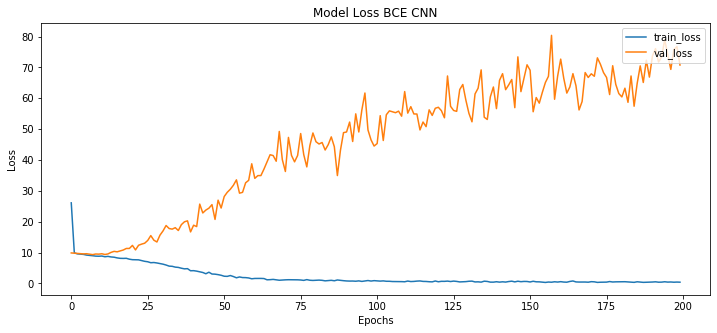

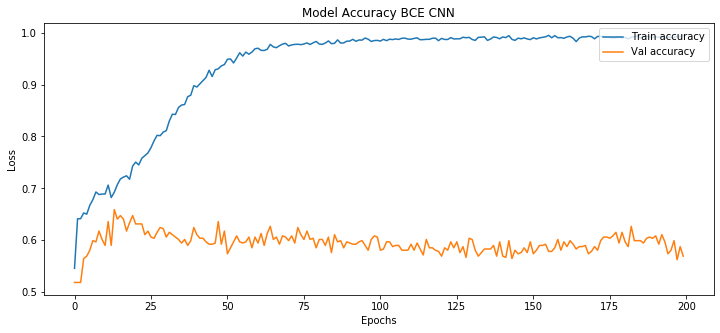

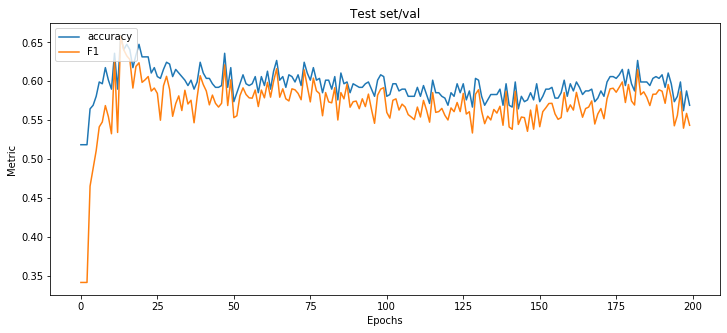

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.689655,0.962310,0.803482,0.63035,0.55604,0.693952
Confirmed,0.735955,0.195231,0.308598,0.63035,0.55604,0.693952


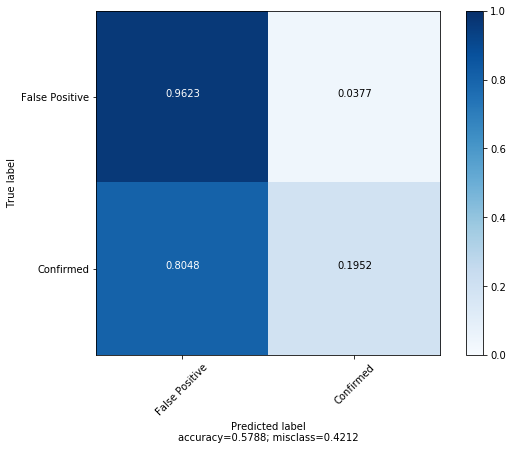

{'Precision raw': array([0.68965517, 0.73595506]),
 'Recall raw': array([0.96230954, 0.195231  ]),
 'F1 raw': array([0.80348175, 0.30859835]),
 'F1 weighted': 0.6303499692881157,
 'F1 macro': 0.5560400526348374,
 'F1 micro': 0.6939520333680917,
 'Confusion Matrix': array([[1200,   47],
        [ 540,  131]])}

In [21]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

### GADF + GASF (30)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.6695 - acc: 0.6376 - val_loss: 0.6756 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 3s 734us/step - loss: 0.6107 - acc: 0.6384 - val_loss: 0.6189 - val_acc: 0.5507
 - val_f1: 0.521613 
Epoch 3/200
3905/3905 [==============================] - 3s 642us/step - loss: 0.5895 - acc: 0.6233 - val_loss: 0.6274 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 4/200
3905/3905 [==============================] - 2s 632us/step - loss: 0.5833 - acc: 0.6430 - val_loss: 0.6198 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 5/200
3905/3905 [==============================] - 3s 724us/step - loss: 0.5809 - acc: 0.6376 - val_loss: 0.6155 - val_acc: 0.5392
 - val_f1: 0.424098 
Epoch 6/200
3905/3905 [==============================] - 3s 713us/step - loss: 0.5782 - acc: 0.6471 - val_loss: 0.6252 - val_acc: 0.5184
 - val_f1: 0.349848 
Epoch 7/200
3905/3905 [==============================] - 3s 687us/step - loss: 0.5802 - acc: 0.6499 - val_loss: 0.6156 - val_acc: 0.5668
 - val_f1: 0.476827 
Epoch 8/200
3905/3905 [========

3905/3905 [==============================] - 2s 556us/step - loss: 0.1868 - acc: 0.9298 - val_loss: 1.0383 - val_acc: 0.6336
 - val_f1: 0.625755 
Epoch 105/200
3905/3905 [==============================] - 2s 615us/step - loss: 0.1781 - acc: 0.9380 - val_loss: 1.0609 - val_acc: 0.6313
 - val_f1: 0.623656 
Epoch 106/200
3905/3905 [==============================] - 2s 555us/step - loss: 0.1711 - acc: 0.9350 - val_loss: 1.1019 - val_acc: 0.6336
 - val_f1: 0.623566 
Epoch 107/200
3905/3905 [==============================] - 2s 617us/step - loss: 0.1830 - acc: 0.9332 - val_loss: 1.0576 - val_acc: 0.6267
 - val_f1: 0.618952 
Epoch 108/200
3905/3905 [==============================] - 2s 629us/step - loss: 0.1767 - acc: 0.9298 - val_loss: 1.1371 - val_acc: 0.6129
 - val_f1: 0.599288 
Epoch 109/200
3905/3905 [==============================] - 3s 712us/step - loss: 0.1768 - acc: 0.9334 - val_loss: 1.1009 - val_acc: 0.6336
 - val_f1: 0.622363 
Epoch 110/200
3905/3905 [=============================

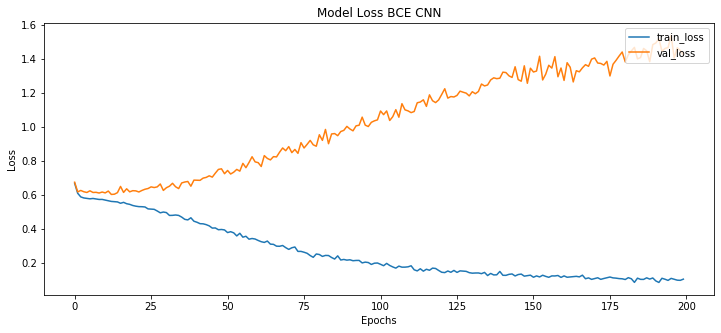

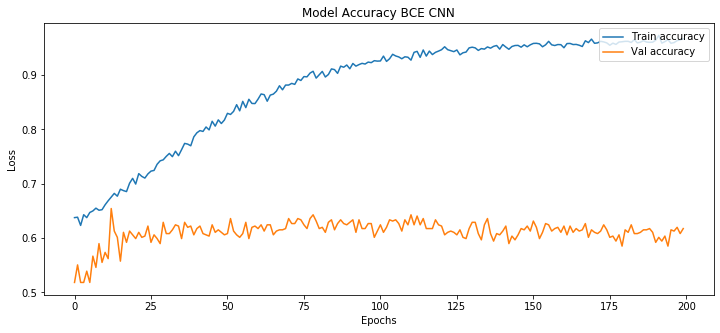

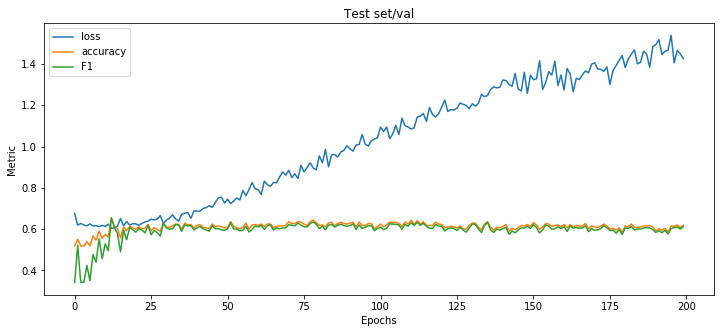

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.751779,0.677626,0.712779,0.650638,0.623967,0.644943
Confirmed,0.493703,0.584203,0.535154,0.650638,0.623967,0.644943


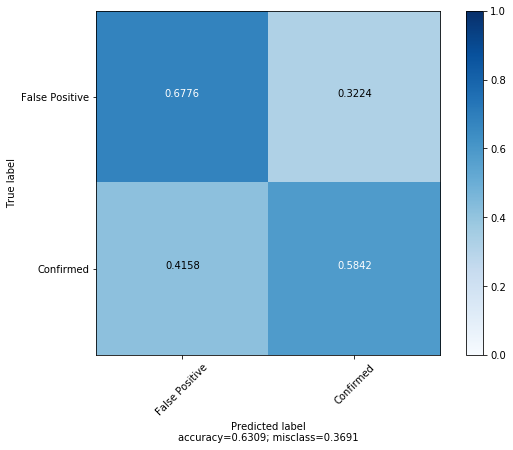

{'Precision raw': array([0.75177936, 0.49370277]),
 'Recall raw': array([0.6776263 , 0.58420268]),
 'F1 raw': array([0.71277942, 0.53515358]),
 'F1 weighted': 0.6506381589220466,
 'F1 macro': 0.623966500792425,
 'F1 micro': 0.6449426485922837,
 'Confusion Matrix': array([[845, 402],
        [279, 392]])}

In [29]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

In [12]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 4s 1ms/step - loss: 10.5100 - acc: 0.6223 - val_loss: 9.8773 - val_acc: 0.5161
 - val_f1: 0.340426 
Epoch 2/200
3905/3905 [==============================] - 3s 689us/step - loss: 9.5290 - acc: 0.6405 - val_loss: 9.4332 - val_acc: 0.5092
 - val_f1: 0.345622 
Epoch 3/200
3905/3905 [==============================] - 2s 589us/step - loss: 9.4130 - acc: 0.6397 - val_loss: 9.3910 - val_acc: 0.5346
 - val_f1: 0.427051 
Epoch 4/200
3905/3905 [==============================] - 3s 702us/step - loss: 9.3486 - acc: 0.6487 - val_loss: 9.5259 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 5/200
 256/3905 [>.............................] - ETA: 2s - loss: 9.3831 - acc: 0.6523

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3905/3905 [==============================] - 2s 625us/step - loss: 9.2690 - acc: 0.6420 - val_loss: 9.5720 - val_acc: 0.5276
 - val_f1: 0.374028 
Epoch 6/200
3905/3905 [==============================] - 2s 624us/step - loss: 9.2474 - acc: 0.6540 - val_loss: 9.6042 - val_acc: 0.5507
 - val_f1: 0.448258 
Epoch 7/200
3905/3905 [==============================] - 2s 586us/step - loss: 9.2589 - acc: 0.6625 - val_loss: 9.3515 - val_acc: 0.5576
 - val_f1: 0.515456 
Epoch 8/200
3905/3905 [==============================] - 2s 580us/step - loss: 9.2303 - acc: 0.6551 - val_loss: 9.4543 - val_acc: 0.5507
 - val_f1: 0.476905 
Epoch 9/200
3905/3905 [==============================] - 3s 692us/step - loss: 9.1601 - acc: 0.6620 - val_loss: 9.4003 - val_acc: 0.5714
 - val_f1: 0.534657 
Epoch 10/200
3905/3905 [==============================] - 2s 633us/step - loss: 9.0985 - acc: 0.6684 - val_loss: 9.6706 - val_acc: 0.5438
 - val_f1: 0.453984 
Epoch 11/200
3905/3905 [==============================] - 3s 68

KeyboardInterrupt: 

### GADF + GASF + MTF(30)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.6543 - acc: 0.6353 - val_loss: 0.6418 - val_acc: 0.5599
 - val_f1: 0.531426 
Epoch 2/200
3905/3905 [==============================] - 2s 534us/step - loss: 0.5891 - acc: 0.6415 - val_loss: 0.6072 - val_acc: 0.6014
 - val_f1: 0.594876 
Epoch 3/200
3905/3905 [==============================] - 2s 584us/step - loss: 0.5669 - acc: 0.6451 - val_loss: 0.5910 - val_acc: 0.6498
 - val_f1: 0.649651 
Epoch 4/200
3905/3905 [==============================] - 2s 617us/step - loss: 0.5590 - acc: 0.6566 - val_loss: 0.5834 - val_acc: 0.6705
 - val_f1: 0.668350 
Epoch 5/200
3905/3905 [==============================] - 2s 562us/step - loss: 0.5535 - acc: 0.6538 - val_loss: 0.5922 - val_acc: 0.6452
 - val_f1: 0.640767 
Epoch 6/200
3905/3905 [==============================] - 2s 518us/step - loss: 0.5446 - acc: 0.6602 - val_loss: 0.5829 - val_acc: 0.6290
 - val_f1: 0.625001 
Epoch 7

3905/3905 [==============================] - 2s 438us/step - loss: 0.1981 - acc: 0.9165 - val_loss: 0.9574 - val_acc: 0.6267
 - val_f1: 0.617334 
Epoch 104/200
3905/3905 [==============================] - 2s 615us/step - loss: 0.1935 - acc: 0.9206 - val_loss: 1.0047 - val_acc: 0.6221
 - val_f1: 0.614757 
Epoch 105/200
3905/3905 [==============================] - 2s 509us/step - loss: 0.1984 - acc: 0.9216 - val_loss: 0.9595 - val_acc: 0.6014
 - val_f1: 0.589776 
Epoch 106/200
3905/3905 [==============================] - 2s 555us/step - loss: 0.1843 - acc: 0.9255 - val_loss: 1.0455 - val_acc: 0.6244
 - val_f1: 0.618738 
Epoch 107/200
3905/3905 [==============================] - 2s 589us/step - loss: 0.1912 - acc: 0.9209 - val_loss: 0.9870 - val_acc: 0.6336
 - val_f1: 0.628094 
Epoch 108/200
3905/3905 [==============================] - 2s 583us/step - loss: 0.1942 - acc: 0.9191 - val_loss: 0.9857 - val_acc: 0.6244
 - val_f1: 0.614096 
Epoch 109/200
3905/3905 [=============================

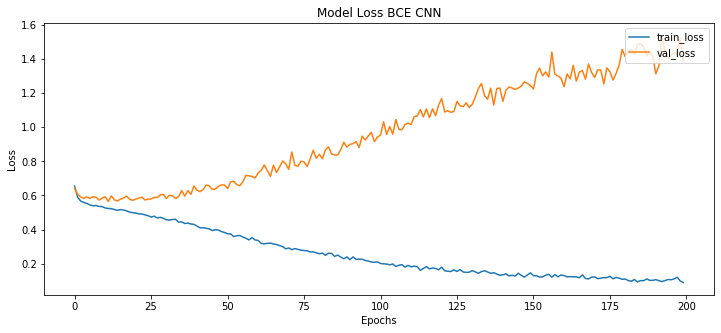

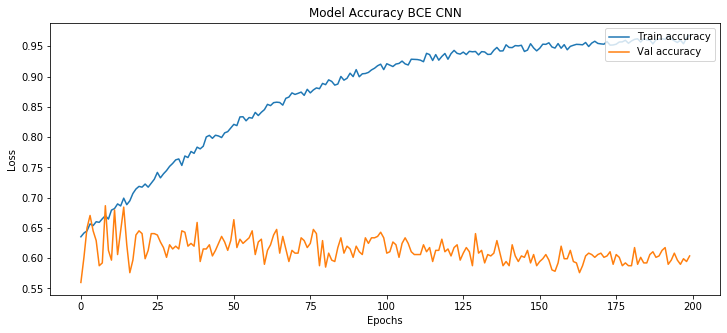

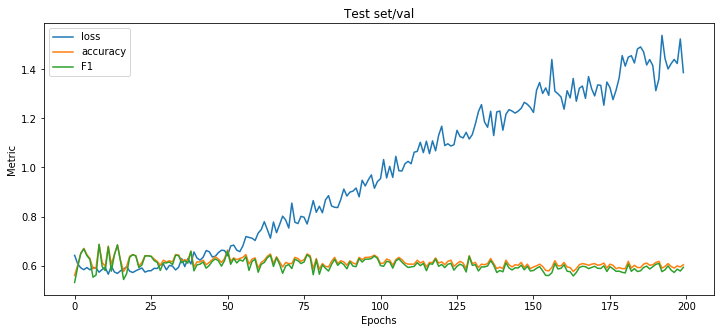

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.846585,0.606255,0.706542,0.679665,0.66813,0.672576
Confirmed,0.520976,0.795827,0.629717,0.679665,0.66813,0.672576


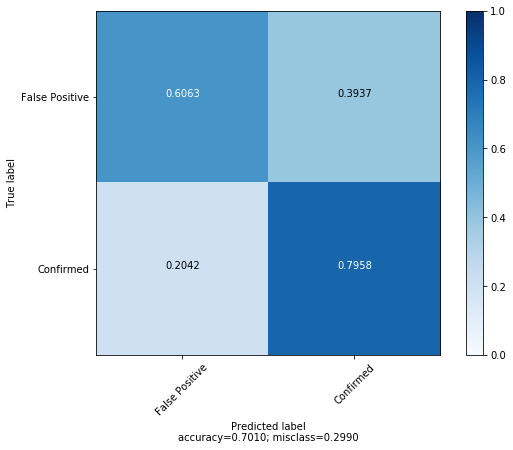

{'Precision raw': array([0.84658455, 0.52097561]),
 'Recall raw': array([0.60625501, 0.79582712]),
 'F1 raw': array([0.70654206, 0.62971698]),
 'F1 weighted': 0.6796652962799044,
 'F1 macro': 0.6681295186034211,
 'F1 micro': 0.6725755995828988,
 'Confusion Matrix': array([[756, 491],
        [137, 534]])}

In [37]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 4s 1ms/step - loss: 10.3520 - acc: 0.6254 - val_loss: 9.4424 - val_acc: 0.5853
 - val_f1: 0.562000 
Epoch 2/200
3905/3905 [==============================] - 2s 460us/step - loss: 9.5021 - acc: 0.6330 - val_loss: 9.2061 - val_acc: 0.5853
 - val_f1: 0.525510 
Epoch 3/200
3905/3905 [==============================] - 2s 577us/step - loss: 9.0509 - acc: 0.6510 - val_loss: 9.0948 - val_acc: 0.5968
 - val_f1: 0.547666 
Epoch 4/200
3905/3905 [==============================] - 3s 763us/step - loss: 8.9420 - acc: 0.6479 - val_loss: 8.8789 - val_acc: 0.6452
 - val_f1: 0.635684 
Epoch 5/200
3905/3905 [==============================] - 2s 614us/step - loss: 8.8288 - acc: 0.6558 - val_loss: 8.8146 - val_acc: 0.6221
 - val_f1: 0.608829 
Epoch 6/200
3905/3905 [==============================] - 3s 677us/step - loss: 8.8568 - acc: 0.6474 - val_loss: 8.8444 - val_acc: 0.6198
 - val_f1: 0.601518 
Epoch 

3905/3905 [==============================] - 2s 479us/step - loss: 3.1697 - acc: 0.9186 - val_loss: 16.5759 - val_acc: 0.6521
 - val_f1: 0.644090 
Epoch 104/200
3905/3905 [==============================] - 2s 542us/step - loss: 3.0844 - acc: 0.9227 - val_loss: 17.7080 - val_acc: 0.6267
 - val_f1: 0.617891 
Epoch 105/200
3905/3905 [==============================] - 2s 634us/step - loss: 3.1734 - acc: 0.9247 - val_loss: 16.4594 - val_acc: 0.6336
 - val_f1: 0.625755 
Epoch 106/200
3905/3905 [==============================] - 3s 657us/step - loss: 3.1408 - acc: 0.9255 - val_loss: 16.5704 - val_acc: 0.6267
 - val_f1: 0.618430 
Epoch 107/200
3905/3905 [==============================] - 2s 594us/step - loss: 3.2067 - acc: 0.9198 - val_loss: 16.9158 - val_acc: 0.6221
 - val_f1: 0.610805 
Epoch 108/200
3905/3905 [==============================] - 2s 553us/step - loss: 3.4212 - acc: 0.9222 - val_loss: 16.5871 - val_acc: 0.6244
 - val_f1: 0.616340 
Epoch 109/200
3905/3905 [=======================

3905/3905 [==============================] - 2s 571us/step - loss: 2.1793 - acc: 0.9488 - val_loss: 22.3825 - val_acc: 0.6221
 - val_f1: 0.609507 
Epoch 155/200
3905/3905 [==============================] - 2s 573us/step - loss: 2.1977 - acc: 0.9475 - val_loss: 23.5234 - val_acc: 0.6406
 - val_f1: 0.630380 
Epoch 156/200
3905/3905 [==============================] - 3s 669us/step - loss: 2.2849 - acc: 0.9449 - val_loss: 24.8058 - val_acc: 0.6429
 - val_f1: 0.629299 
Epoch 157/200
3905/3905 [==============================] - 2s 636us/step - loss: 2.2924 - acc: 0.9385 - val_loss: 24.2393 - val_acc: 0.6060
 - val_f1: 0.590274 
Epoch 158/200
3905/3905 [==============================] - 3s 666us/step - loss: 2.2958 - acc: 0.9506 - val_loss: 24.6156 - val_acc: 0.6175
 - val_f1: 0.608457 
Epoch 159/200
3905/3905 [==============================] - 3s 662us/step - loss: 2.2087 - acc: 0.9488 - val_loss: 25.1444 - val_acc: 0.6336
 - val_f1: 0.621086 
Epoch 160/200
3905/3905 [=======================

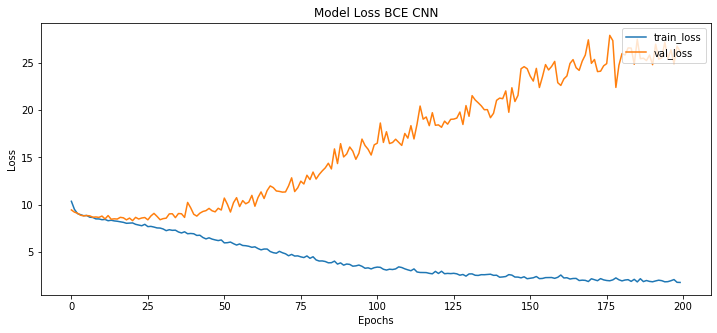

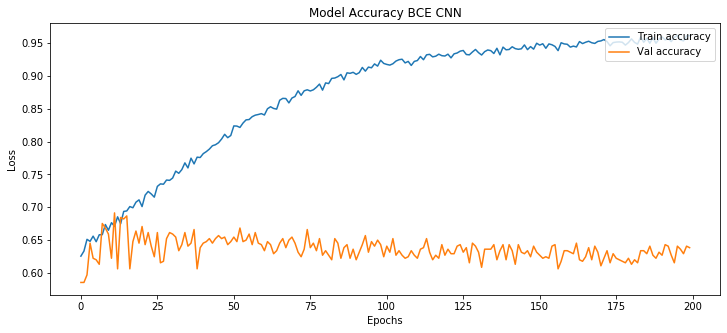

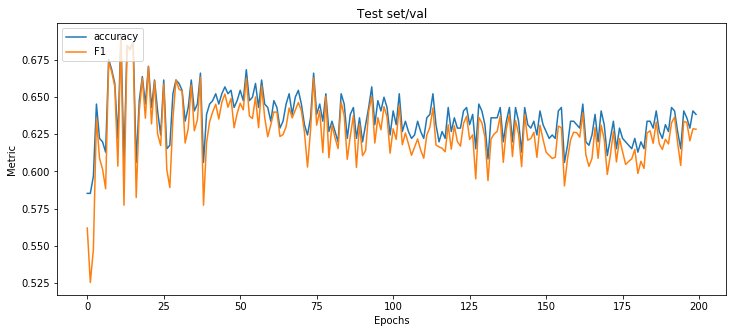

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.823411,0.654370,0.729223,0.691283,0.674999,0.684046
Confirmed,0.535059,0.739195,0.620776,0.691283,0.674999,0.684046


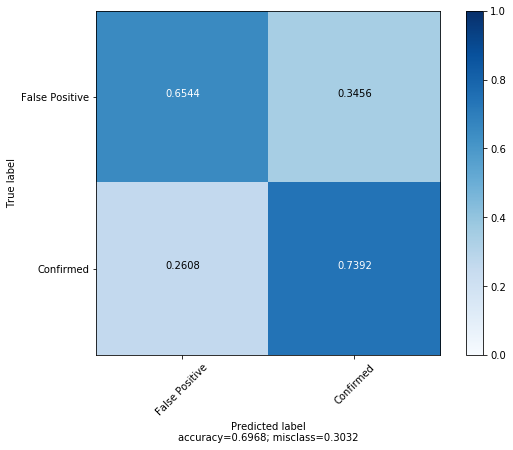

{'Precision raw': array([0.8234107 , 0.53505933]),
 'Recall raw': array([0.65437049, 0.73919523]),
 'F1 raw': array([0.72922252, 0.62077597]),
 'F1 weighted': 0.6912831899992349,
 'F1 macro': 0.6749992450348459,
 'F1 micro': 0.6840458811261731,
 'Confusion Matrix': array([[816, 431],
        [175, 496]])}

In [38]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

In [ ]:
## tamaño 64

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.6532 - acc: 0.6266 - val_loss: 0.6580 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 7s 2ms/step - loss: 0.6057 - acc: 0.6476 - val_loss: 0.6325 - val_acc: 0.5438
 - val_f1: 0.407741 
Epoch 3/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.5866 - acc: 0.6545 - val_loss: 0.6441 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 4/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.5782 - acc: 0.6717 - val_loss: 0.6090 - val_acc: 0.6382
 - val_f1: 0.637554 
Epoch 5/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.5529 - acc: 0.6858 - val_loss: 0.6026 - val_acc: 0.6406
 - val_f1: 0.618655 
Epoch 6/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.5434 - acc: 0.6988 - val_loss: 0.5892 - val_acc: 0.6705
 - val_f1: 0.669029 
Epoch 7/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.5339 - acc: 0.6976 - val_loss: 0.5697 - val_acc: 0.6820
 - val_f1: 0.679022 
Epoch 8/200
3905/3905 [====================

3905/3905 [==============================] - 5s 1ms/step - loss: 0.1619 - acc: 0.9342 - val_loss: 0.8749 - val_acc: 0.6567
 - val_f1: 0.655876 
Epoch 55/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.1425 - acc: 0.9467 - val_loss: 0.9017 - val_acc: 0.6682
 - val_f1: 0.662169 
Epoch 56/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.1500 - acc: 0.9444 - val_loss: 0.9191 - val_acc: 0.6590
 - val_f1: 0.655112 
Epoch 57/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.1320 - acc: 0.9472 - val_loss: 0.9681 - val_acc: 0.6452
 - val_f1: 0.637273 
Epoch 58/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.1333 - acc: 0.9462 - val_loss: 0.9769 - val_acc: 0.6475
 - val_f1: 0.643282 
Epoch 59/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.1387 - acc: 0.9470 - val_loss: 0.8758 - val_acc: 0.6521
 - val_f1: 0.648293 
Epoch 60/200
3905/3905 [==============================] - 4s 1ms/step -

3905/3905 [==============================] - 5s 1ms/step - loss: 0.0496 - acc: 0.9816 - val_loss: 1.4544 - val_acc: 0.6498
 - val_f1: 0.642945 
Epoch 107/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.0521 - acc: 0.9823 - val_loss: 1.4146 - val_acc: 0.6221
 - val_f1: 0.610805 
Epoch 108/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.0565 - acc: 0.9787 - val_loss: 1.5179 - val_acc: 0.6382
 - val_f1: 0.626492 
Epoch 109/200
3905/3905 [==============================] - 4s 974us/step - loss: 0.0558 - acc: 0.9787 - val_loss: 1.5172 - val_acc: 0.6429
 - val_f1: 0.633036 
Epoch 110/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.0559 - acc: 0.9798 - val_loss: 1.4191 - val_acc: 0.6567
 - val_f1: 0.647779 
Epoch 111/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.0576 - acc: 0.9787 - val_loss: 1.3339 - val_acc: 0.6521
 - val_f1: 0.646806 
Epoch 112/200
3905/3905 [==============================] - 4s 1m

3905/3905 [==============================] - 4s 1ms/step - loss: 0.0325 - acc: 0.9875 - val_loss: 1.8039 - val_acc: 0.6406
 - val_f1: 0.632043 
Epoch 159/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.0331 - acc: 0.9892 - val_loss: 1.8568 - val_acc: 0.6359
 - val_f1: 0.624428 
Epoch 160/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.0361 - acc: 0.9851 - val_loss: 1.9379 - val_acc: 0.6290
 - val_f1: 0.620520 
Epoch 161/200
3905/3905 [==============================] - 4s 968us/step - loss: 0.0382 - acc: 0.9875 - val_loss: 1.8897 - val_acc: 0.6359
 - val_f1: 0.626782 
Epoch 162/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.0403 - acc: 0.9818 - val_loss: 1.9217 - val_acc: 0.6521
 - val_f1: 0.638196 
Epoch 163/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.0360 - acc: 0.9875 - val_loss: 1.8216 - val_acc: 0.6521
 - val_f1: 0.645062 
Epoch 164/200
3905/3905 [==============================] - 4s 1m

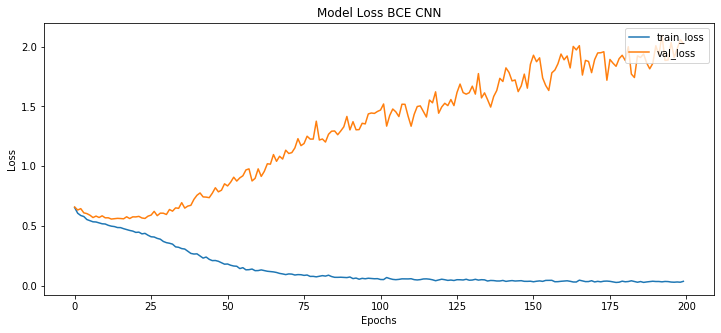

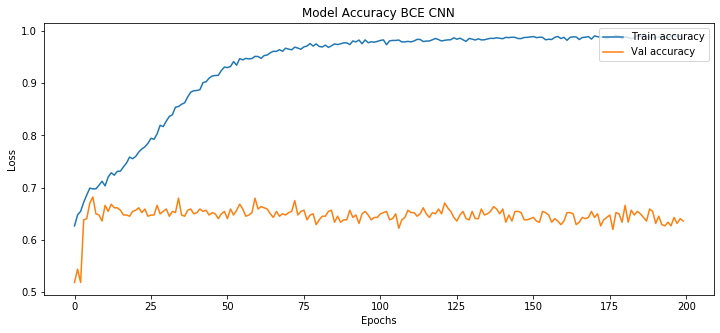

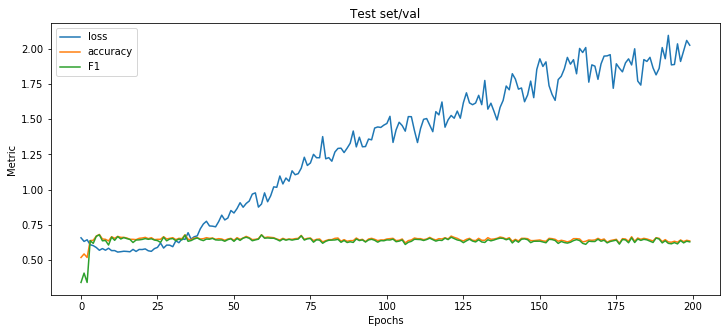

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.753414,0.796311,0.774269,0.693869,0.659361,0.698123
Confirmed,0.576667,0.515648,0.544453,0.693869,0.659361,0.698123


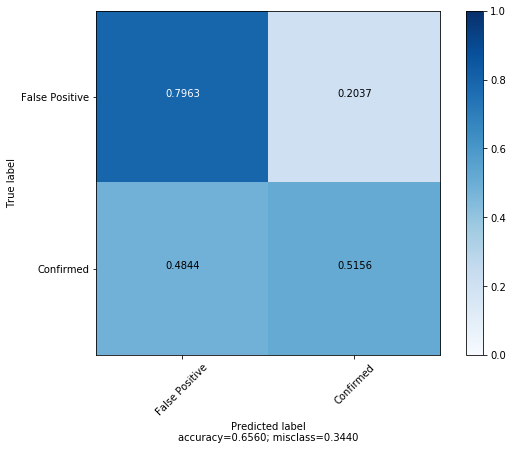

{'Precision raw': array([0.75341426, 0.57666667]),
 'Recall raw': array([0.79631115, 0.51564829]),
 'F1 raw': array([0.77426901, 0.54445319]),
 'F1 weighted': 0.6938694152304424,
 'F1 macro': 0.6593610961576508,
 'F1 micro': 0.6981230448383733,
 'Confusion Matrix': array([[993, 254],
        [325, 346]])}

In [33]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 6s 2ms/step - loss: 12.2434 - acc: 0.5987 - val_loss: 9.7979 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 4s 967us/step - loss: 9.8077 - acc: 0.6420 - val_loss: 9.6117 - val_acc: 0.5230
 - val_f1: 0.351944 
Epoch 3/200
3905/3905 [==============================] - 5s 1ms/step - loss: 9.7129 - acc: 0.6494 - val_loss: 9.6125 - val_acc: 0.5184
 - val_f1: 0.341426 
Epoch 4/200
3905/3905 [==============================] - 3s 789us/step - loss: 9.3767 - acc: 0.6545 - val_loss: 9.5465 - val_acc: 0.5230
 - val_f1: 0.351944 
Epoch 5/200
3905/3905 [==============================] - 3s 881us/step - loss: 9.1550 - acc: 0.6668 - val_loss: 9.2837 - val_acc: 0.5899
 - val_f1: 0.534222 
Epoch 6/200
3905/3905 [==============================] - 4s 912us/step - loss: 9.1014 - acc: 0.6766 - val_loss: 9.2513 - val_acc: 0.5899
 - val_f1: 0.527198 
Epoch 7/200
3905/3905 [==============================] - 4s 1ms/step - loss: 9.0036 - acc: 0.6832 - val_loss: 9.1419 - val_acc: 0.6198
 - val_f1: 0.593206 
Epoch 8/200
3905/3905 [============

3905/3905 [==============================] - 5s 1ms/step - loss: 3.7894 - acc: 0.9083 - val_loss: 12.8693 - val_acc: 0.6521
 - val_f1: 0.645062 
Epoch 55/200
3905/3905 [==============================] - 4s 1ms/step - loss: 3.6014 - acc: 0.9050 - val_loss: 14.6438 - val_acc: 0.6590
 - val_f1: 0.650913 
Epoch 56/200
3905/3905 [==============================] - 4s 1ms/step - loss: 3.4756 - acc: 0.9117 - val_loss: 16.3133 - val_acc: 0.6406
 - val_f1: 0.629790 
Epoch 57/200
3905/3905 [==============================] - 5s 1ms/step - loss: 3.5168 - acc: 0.9132 - val_loss: 14.8064 - val_acc: 0.6544
 - val_f1: 0.640252 
Epoch 58/200
3905/3905 [==============================] - 5s 1ms/step - loss: 3.4482 - acc: 0.9178 - val_loss: 13.7133 - val_acc: 0.6498
 - val_f1: 0.647607 
Epoch 59/200
3905/3905 [==============================] - 5s 1ms/step - loss: 3.2418 - acc: 0.9196 - val_loss: 14.2754 - val_acc: 0.6636
 - val_f1: 0.658695 
Epoch 60/200
3905/3905 [==============================] - 5s 1ms/

 - val_f1: 0.650789 
Epoch 106/200
3905/3905 [==============================] - 4s 1ms/step - loss: 1.2062 - acc: 0.9759 - val_loss: 28.2682 - val_acc: 0.6359
 - val_f1: 0.629325 
Epoch 107/200
3905/3905 [==============================] - 4s 1ms/step - loss: 1.1239 - acc: 0.9770 - val_loss: 29.7830 - val_acc: 0.6336
 - val_f1: 0.622363 
Epoch 108/200
3905/3905 [==============================] - 4s 1ms/step - loss: 1.2351 - acc: 0.9754 - val_loss: 27.8477 - val_acc: 0.6290
 - val_f1: 0.618831 
Epoch 109/200
3905/3905 [==============================] - 4s 1ms/step - loss: 1.1128 - acc: 0.9767 - val_loss: 28.6587 - val_acc: 0.6544
 - val_f1: 0.644029 
Epoch 110/200
3905/3905 [==============================] - 5s 1ms/step - loss: 1.2036 - acc: 0.9741 - val_loss: 28.3193 - val_acc: 0.6521
 - val_f1: 0.641364 
Epoch 111/200
3905/3905 [==============================] - 5s 1ms/step - loss: 1.1196 - acc: 0.9770 - val_loss: 29.4473 - val_acc: 0.6613
 - val_f1: 0.651976 
Epoch 112/200
3905/3905 [

3905/3905 [==============================] - 5s 1ms/step - loss: 0.8196 - acc: 0.9836 - val_loss: 36.3311 - val_acc: 0.6475
 - val_f1: 0.637201 
Epoch 158/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.8561 - acc: 0.9836 - val_loss: 34.2168 - val_acc: 0.6498
 - val_f1: 0.639283 
Epoch 159/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.8407 - acc: 0.9844 - val_loss: 32.5216 - val_acc: 0.6521
 - val_f1: 0.644090 
Epoch 160/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.7179 - acc: 0.9854 - val_loss: 33.7273 - val_acc: 0.6636
 - val_f1: 0.657899 
Epoch 161/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.7512 - acc: 0.9857 - val_loss: 31.0617 - val_acc: 0.6682
 - val_f1: 0.664757 
Epoch 162/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.8698 - acc: 0.9800 - val_loss: 35.0673 - val_acc: 0.6498
 - val_f1: 0.638690 
Epoch 163/200
3905/3905 [==============================] - 5

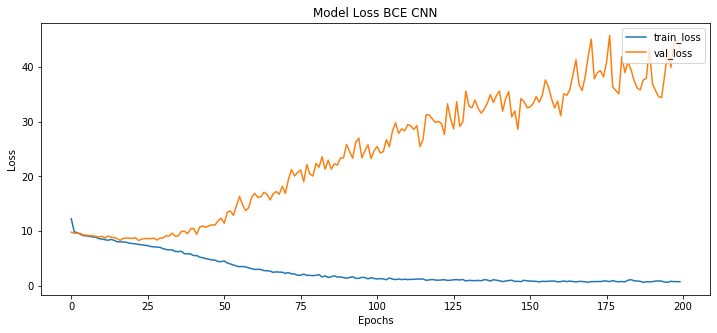

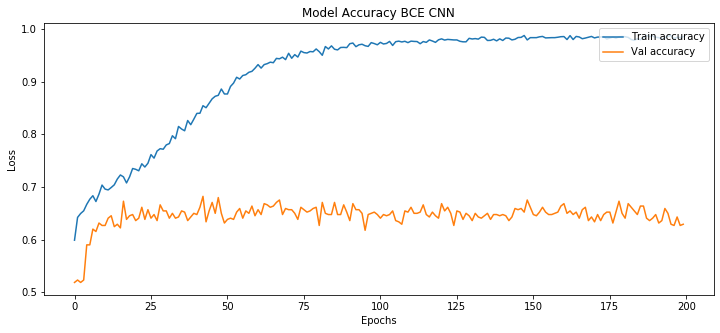

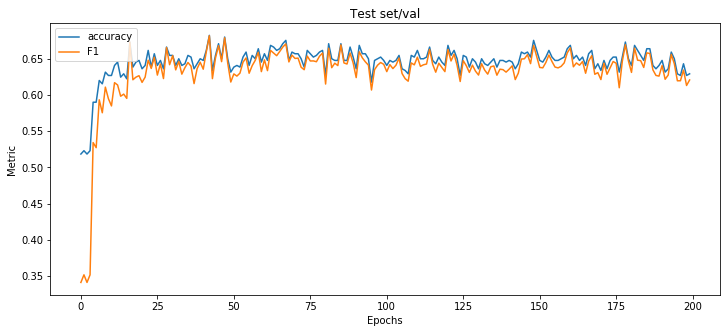

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.732881,0.866881,0.794269,0.690379,0.645788,0.708029
Confirmed,0.625282,0.412817,0.497307,0.690379,0.645788,0.708029


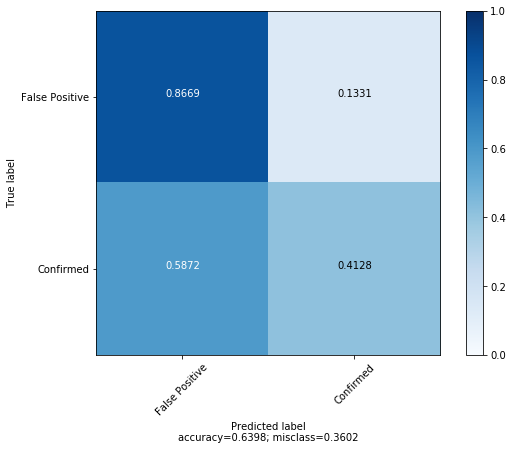

{'Precision raw': array([0.73288136, 0.62528217]),
 'Recall raw': array([0.86688051, 0.41281669]),
 'F1 raw': array([0.79426892, 0.497307  ]),
 'F1 weighted': 0.6903786972548068,
 'F1 macro': 0.6457879608535808,
 'F1 micro': 0.708029197080292,
 'Confusion Matrix': array([[1081,  166],
        [ 394,  277]])}

In [34]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

### GADF + GASF + Time (30)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.6429 - acc: 0.6325 - val_loss: 0.6696 - val_acc: 0.5000
 - val_f1: 0.363469 
Epoch 2/200
3905/3905 [==============================] - 2s 405us/step - loss: 0.6071 - acc: 0.6364 - val_loss: 0.6375 - val_acc: 0.5138
 - val_f1: 0.387657 
Epoch 3/200
3905/3905 [==============================] - 2s 546us/step - loss: 0.5895 - acc: 0.6315 - val_loss: 0.6232 - val_acc: 0.5161
 - val_f1: 0.340426 
Epoch 4/200
3905/3905 [==============================] - 2s 545us/step - loss: 0.5811 - acc: 0.6405 - val_loss: 0.6194 - val_acc: 0.5323
 - val_f1: 0.422793 
Epoch 5/200
3905/3905 [==============================] - 2s 456us/step - loss: 0.5793 - acc: 0.6438 - val_loss: 0.6146 - val_acc: 0.5991
 - val_f1: 0.581888 
Epoch 6/200
3905/3905 [==============================] - 2s 601us/step - loss: 0.5771 - acc: 0.6533 - val_loss: 0.6189 - val_acc: 0.5392
 - val_f1: 0.443433 
Epoch 7

3905/3905 [==============================] - 2s 595us/step - loss: 0.1905 - acc: 0.9255 - val_loss: 1.1339 - val_acc: 0.5829
 - val_f1: 0.573380 
Epoch 104/200
3905/3905 [==============================] - 3s 656us/step - loss: 0.1848 - acc: 0.9319 - val_loss: 1.1424 - val_acc: 0.6083
 - val_f1: 0.596566 
Epoch 105/200
3905/3905 [==============================] - 2s 627us/step - loss: 0.1910 - acc: 0.9278 - val_loss: 1.1954 - val_acc: 0.6037
 - val_f1: 0.588263 
Epoch 106/200
3905/3905 [==============================] - 2s 583us/step - loss: 0.1882 - acc: 0.9260 - val_loss: 1.1658 - val_acc: 0.6083
 - val_f1: 0.600134 
Epoch 107/200
3905/3905 [==============================] - 2s 593us/step - loss: 0.1904 - acc: 0.9245 - val_loss: 1.1937 - val_acc: 0.6198
 - val_f1: 0.611632 
Epoch 108/200
3905/3905 [==============================] - 2s 587us/step - loss: 0.1849 - acc: 0.9293 - val_loss: 1.1430 - val_acc: 0.6037
 - val_f1: 0.597455 
Epoch 109/200
3905/3905 [=============================

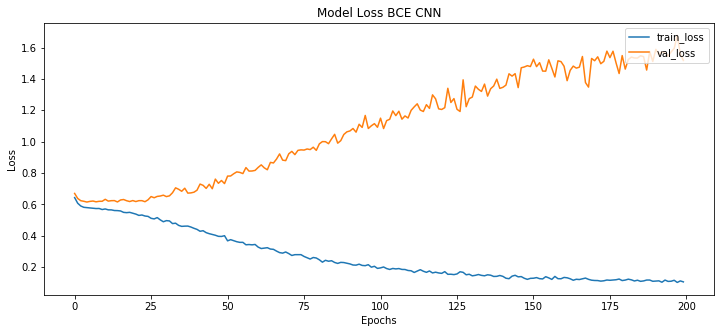

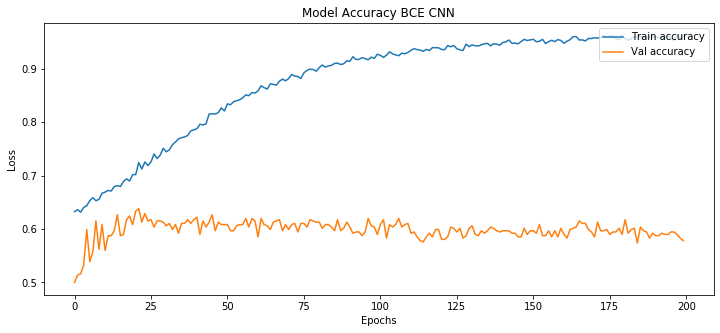

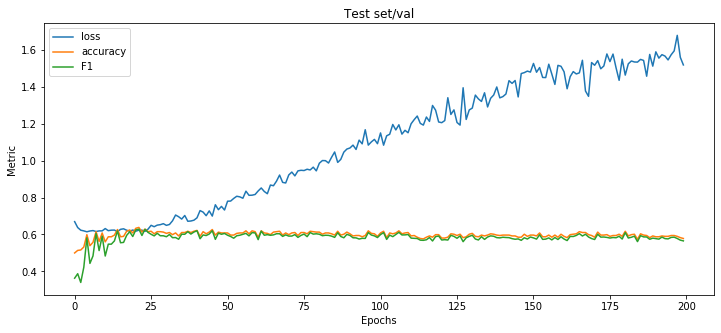

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.716912,0.781877,0.747986,0.649132,0.606703,0.657456
Confirmed,0.512545,0.426230,0.465419,0.649132,0.606703,0.657456


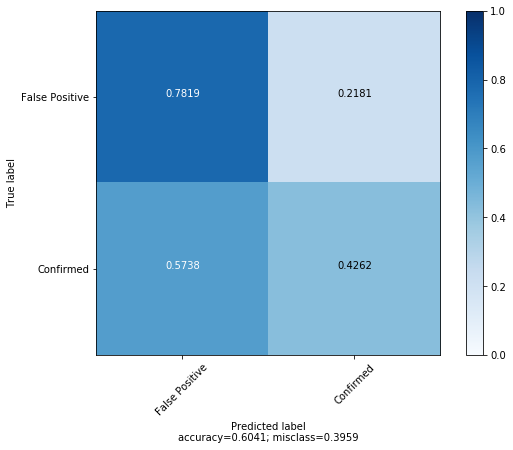

{'Precision raw': array([0.71691176, 0.5125448 ]),
 'Recall raw': array([0.7818765 , 0.42622951]),
 'F1 raw': array([0.74798619, 0.46541904]),
 'F1 weighted': 0.6491318852762143,
 'F1 macro': 0.6067026154469892,
 'F1 micro': 0.6574556830031283,
 'Confusion Matrix': array([[975, 272],
        [385, 286]])}

In [41]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 5s 1ms/step - loss: 10.6491 - acc: 0.6128 - val_loss: 9.9178 - val_acc: 0.5184


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - val_f1: 0.341426 
Epoch 2/200
3905/3905 [==============================] - 1s 383us/step - loss: 9.7166 - acc: 0.6356 - val_loss: 9.5173 - val_acc: 0.5046
 - val_f1: 0.351271 
Epoch 3/200
3905/3905 [==============================] - 2s 580us/step - loss: 9.4574 - acc: 0.6448 - val_loss: 9.3579 - val_acc: 0.6613
 - val_f1: 0.651428 
Epoch 4/200
3905/3905 [==============================] - 2s 469us/step - loss: 9.4364 - acc: 0.6412 - val_loss: 9.3769 - val_acc: 0.5161
 - val_f1: 0.352846 
Epoch 5/200
3905/3905 [==============================] - 2s 452us/step - loss: 9.3145 - acc: 0.6474 - val_loss: 9.2982 - val_acc: 0.5876
 - val_f1: 0.570290 
Epoch 6/200
3905/3905 [==============================] - 2s 530us/step - loss: 9.3196 - acc: 0.6510 - val_loss: 9.3227 - val_acc: 0.5438
 - val_f1: 0.474075 
Epoch 7/200
3905/3905 [==============================] - 1s 315us/step - loss: 9.2548 - acc: 0.6502 - val_loss: 9.3231 - val_acc: 0.5829
 - val_f1: 0.565489 
Epoch 8/200
3905/3905 [========

3905/3905 [==============================] - 2s 453us/step - loss: 2.9626 - acc: 0.9393 - val_loss: 20.2839 - val_acc: 0.6129
 - val_f1: 0.597082 
Epoch 105/200
3905/3905 [==============================] - 2s 477us/step - loss: 3.0834 - acc: 0.9293 - val_loss: 20.5406 - val_acc: 0.6106
 - val_f1: 0.591858 
Epoch 106/200
3905/3905 [==============================] - 2s 432us/step - loss: 2.7998 - acc: 0.9398 - val_loss: 19.5151 - val_acc: 0.6175
 - val_f1: 0.604058 
Epoch 107/200
3905/3905 [==============================] - 2s 516us/step - loss: 2.7584 - acc: 0.9411 - val_loss: 19.6149 - val_acc: 0.6037
 - val_f1: 0.589015 
Epoch 108/200
3905/3905 [==============================] - 2s 539us/step - loss: 3.0297 - acc: 0.9347 - val_loss: 21.5876 - val_acc: 0.5968
 - val_f1: 0.574641 
Epoch 109/200
3905/3905 [==============================] - 2s 400us/step - loss: 2.8206 - acc: 0.9355 - val_loss: 21.0591 - val_acc: 0.6129
 - val_f1: 0.597838 
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 2s 543us/step - loss: 1.9574 - acc: 0.9585 - val_loss: 25.3029 - val_acc: 0.6244
 - val_f1: 0.613489 
Epoch 156/200
3905/3905 [==============================] - 1s 365us/step - loss: 2.1764 - acc: 0.9567 - val_loss: 25.7086 - val_acc: 0.6221
 - val_f1: 0.605139 
Epoch 157/200
3905/3905 [==============================] - 1s 341us/step - loss: 2.2330 - acc: 0.9562 - val_loss: 26.4914 - val_acc: 0.6106
 - val_f1: 0.593505 
Epoch 158/200
3905/3905 [==============================] - 2s 512us/step - loss: 2.2952 - acc: 0.9526 - val_loss: 24.9645 - val_acc: 0.6014
 - val_f1: 0.583052 
Epoch 159/200
3905/3905 [==============================] - 2s 527us/step - loss: 1.9034 - acc: 0.9557 - val_loss: 26.1067 - val_acc: 0.5945
 - val_f1: 0.573607 
Epoch 160/200
3905/3905 [==============================] - 2s 457us/step - loss: 2.1059 - acc: 0.9542 - val_loss: 24.4906 - val_acc: 0.6037
 - val_f1: 0.590458 
Epoch 161/200
3905/3905 [=======================

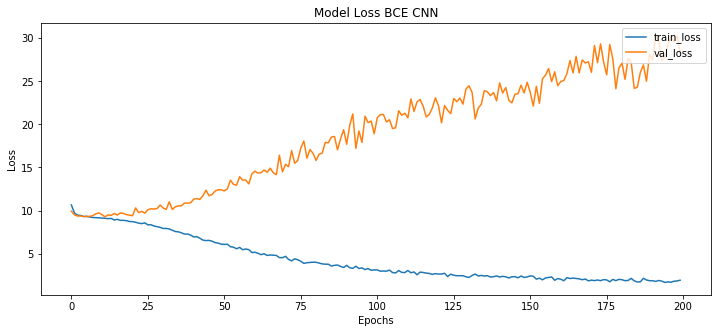

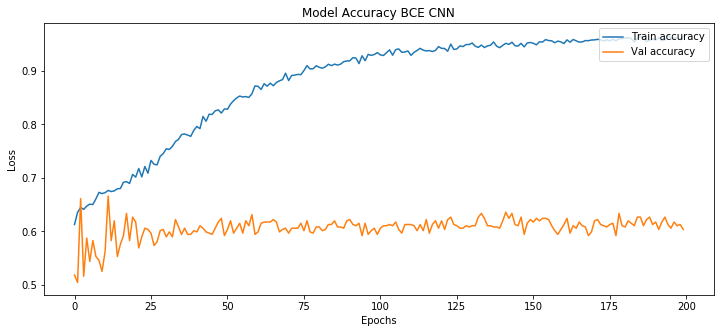

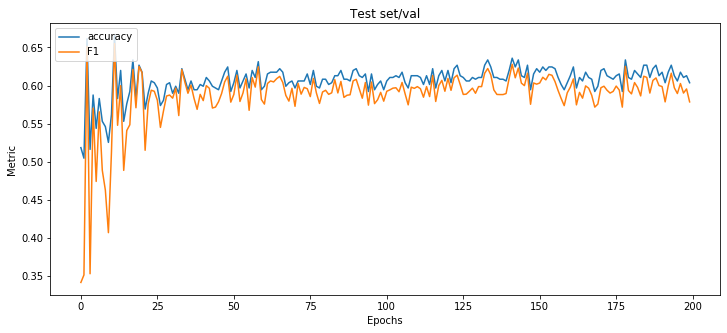

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.733086,0.790698,0.760802,0.670125,0.631205,0.676747
Confirmed,0.544503,0.464978,0.501608,0.670125,0.631205,0.676747


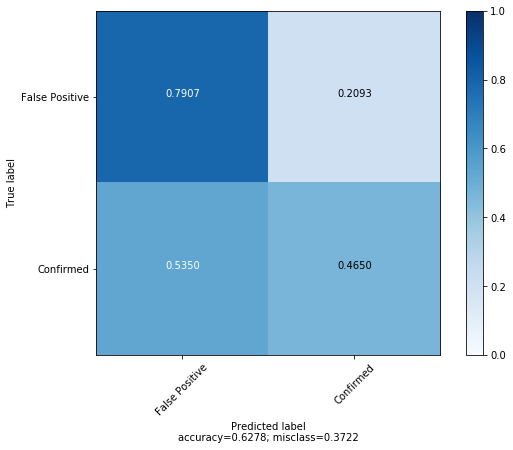

{'Precision raw': array([0.7330855 , 0.54450262]),
 'Recall raw': array([0.79069767, 0.46497765]),
 'F1 raw': array([0.76080247, 0.50160772]),
 'F1 weighted': 0.6701248473135527,
 'F1 macro': 0.6312050930888016,
 'F1 micro': 0.6767466110531803,
 'Confusion Matrix': array([[986, 261],
        [359, 312]])}

In [42]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

### GADF + GASF + MTF + Time (30) -- todo

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.6434 - acc: 0.6287 - val_loss: 0.6491 - val_acc: 0.5392
 - val_f1: 0.485648 
Epoch 2/200
3905/3905 [==============================] - 2s 561us/step - loss: 0.5997 - acc: 0.6343 - val_loss: 0.6219 - val_acc: 0.5323
 - val_f1: 0.404535 
Epoch 3/200
3905/3905 [==============================] - 2s 587us/step - loss: 0.5756 - acc: 0.6448 - val_loss: 0.5983 - val_acc: 0.6567
 - val_f1: 0.655715 
Epoch 4/200
3905/3905 [==============================] - 2s 455us/step - loss: 0.5669 - acc: 0.6407 - val_loss: 0.5878 - val_acc: 0.6774
 - val_f1: 0.677248 
Epoch 5/200
3905/3905 [==============================] - 2s 529us/step - loss: 0.5585 - acc: 0.6520 - val_loss: 0.5911 - val_acc: 0.5783
 - val_f1: 0.538853 
Epoch 6/200
3905/3905 [==============================] - 2s 510us/step - loss: 0.5502 - acc: 0.6609 - val_loss: 0.5846 - val_acc: 0.6452
 - val_f1: 0.638709 
Epoch 7

3905/3905 [==============================] - 3s 652us/step - loss: 0.2009 - acc: 0.9214 - val_loss: 0.9271 - val_acc: 0.6336
 - val_f1: 0.627210 
Epoch 104/200
3905/3905 [==============================] - 2s 633us/step - loss: 0.2022 - acc: 0.9173 - val_loss: 0.9266 - val_acc: 0.6221
 - val_f1: 0.610165 
Epoch 105/200
3905/3905 [==============================] - 2s 565us/step - loss: 0.2026 - acc: 0.9157 - val_loss: 0.9566 - val_acc: 0.6290
 - val_f1: 0.619975 
Epoch 106/200
3905/3905 [==============================] - 2s 565us/step - loss: 0.1916 - acc: 0.9229 - val_loss: 0.9523 - val_acc: 0.6290
 - val_f1: 0.620520 
Epoch 107/200
3905/3905 [==============================] - 3s 719us/step - loss: 0.1976 - acc: 0.9150 - val_loss: 0.9848 - val_acc: 0.6267
 - val_f1: 0.612910 
Epoch 108/200
3905/3905 [==============================] - 3s 663us/step - loss: 0.1983 - acc: 0.9211 - val_loss: 0.9308 - val_acc: 0.6429
 - val_f1: 0.637028 
Epoch 109/200
3905/3905 [=============================

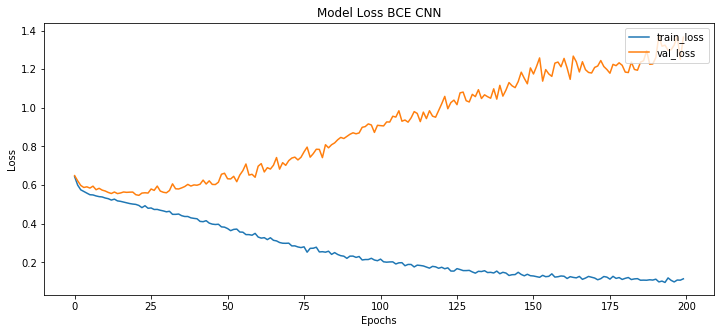

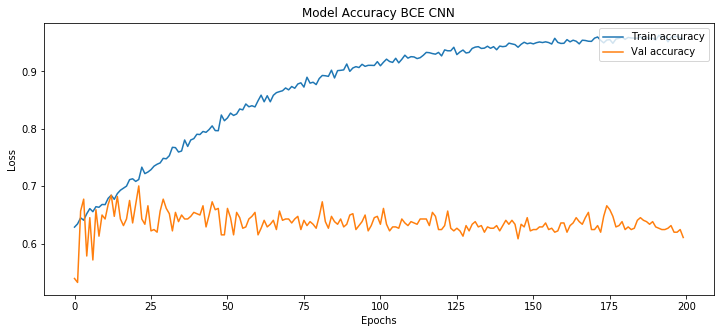

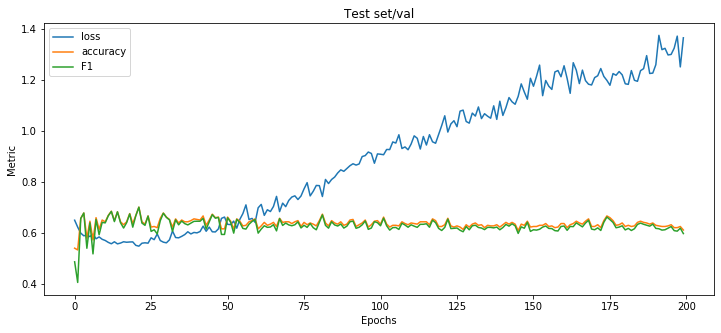

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.81639,0.631115,0.711895,0.675548,0.659948,0.667883
Confirmed,0.51782,0.736215,0.608000,0.675548,0.659948,0.667883


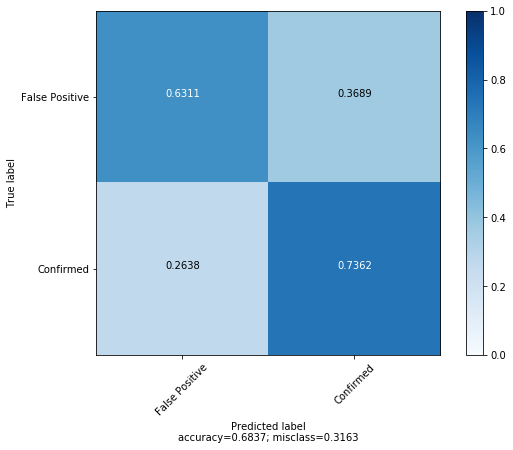

{'Precision raw': array([0.81639004, 0.51781971]),
 'Recall raw': array([0.63111468, 0.73621461]),
 'F1 raw': array([0.71189507, 0.608     ]),
 'F1 weighted': 0.6755480460999581,
 'F1 macro': 0.6599475350520126,
 'F1 micro': 0.6678832116788321,
 'Confusion Matrix': array([[787, 460],
        [177, 494]])}

In [45]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 6s 1ms/step - loss: 10.5490 - acc: 0.6241 - val_loss: 9.7730 - val_acc: 0.5115
 - val_f1: 0.342593 
Epoch 2/200
3905/3905 [==============================] - 2s 567us/step - loss: 9.5622 - acc: 0.6356 - val_loss: 9.2378 - val_acc: 0.5323
 - val_f1: 0.397927 
Epoch 3/200
3905/3905 [==============================] - 3s 744us/step - loss: 9.1907 - acc: 0.6438 - val_loss: 9.0656 - val_acc: 0.5968
 - val_f1: 0.584362 
Epoch 4/200
3905/3905 [==============================] - 3s 668us/step - loss: 9.0295 - acc: 0.6530 - val_loss: 8.8359 - val_acc: 0.6774
 - val_f1: 0.674656 
Epoch 5/200
3905/3905 [==============================] - 2s 607us/step - loss: 8.9885 - acc: 0.6407 - val_loss: 8.9669 - val_acc: 0.6014
 - val_f1: 0.587722 
Epoch 6/200
3905/3905 [==============================] - 2s 541us/step - loss: 8.8240 - acc: 0.6456 - val_loss: 8.7688 - val_acc: 0.7074
 - val_f1: 0.707185 
Epoch 

3905/3905 [==============================] - 2s 406us/step - loss: 2.9553 - acc: 0.9273 - val_loss: 17.0138 - val_acc: 0.6336
 - val_f1: 0.630342 
Epoch 104/200
3905/3905 [==============================] - 2s 477us/step - loss: 2.8978 - acc: 0.9303 - val_loss: 16.9890 - val_acc: 0.6175
 - val_f1: 0.604058 
Epoch 105/200
3905/3905 [==============================] - 2s 416us/step - loss: 3.0411 - acc: 0.9268 - val_loss: 17.2505 - val_acc: 0.6244
 - val_f1: 0.616855 
Epoch 106/200
3905/3905 [==============================] - 2s 454us/step - loss: 2.8486 - acc: 0.9314 - val_loss: 17.1592 - val_acc: 0.6244
 - val_f1: 0.610869 
Epoch 107/200
3905/3905 [==============================] - 2s 579us/step - loss: 2.9137 - acc: 0.9324 - val_loss: 17.3477 - val_acc: 0.6129
 - val_f1: 0.603161 
Epoch 108/200
3905/3905 [==============================] - 2s 633us/step - loss: 2.9680 - acc: 0.9350 - val_loss: 16.1832 - val_acc: 0.6544
 - val_f1: 0.651983 
Epoch 109/200
3905/3905 [=======================

3905/3905 [==============================] - 2s 590us/step - loss: 2.0739 - acc: 0.9503 - val_loss: 23.1418 - val_acc: 0.5991
 - val_f1: 0.590166 
Epoch 155/200
3905/3905 [==============================] - 2s 574us/step - loss: 2.1126 - acc: 0.9490 - val_loss: 24.1071 - val_acc: 0.5876
 - val_f1: 0.573423 
Epoch 156/200
3905/3905 [==============================] - 2s 598us/step - loss: 2.1693 - acc: 0.9519 - val_loss: 21.9737 - val_acc: 0.6175
 - val_f1: 0.612367 
Epoch 157/200
3905/3905 [==============================] - 2s 630us/step - loss: 2.0225 - acc: 0.9562 - val_loss: 23.8731 - val_acc: 0.6014
 - val_f1: 0.587722 
Epoch 158/200
3905/3905 [==============================] - 2s 564us/step - loss: 1.8839 - acc: 0.9624 - val_loss: 23.0945 - val_acc: 0.6152
 - val_f1: 0.607453 
Epoch 159/200
3905/3905 [==============================] - 3s 675us/step - loss: 2.0519 - acc: 0.9534 - val_loss: 22.7048 - val_acc: 0.6152
 - val_f1: 0.606925 
Epoch 160/200
3905/3905 [=======================

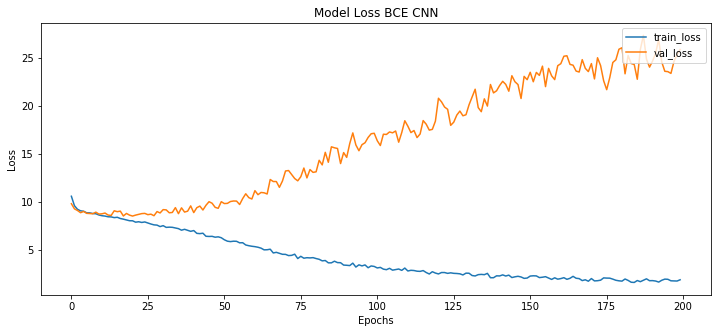

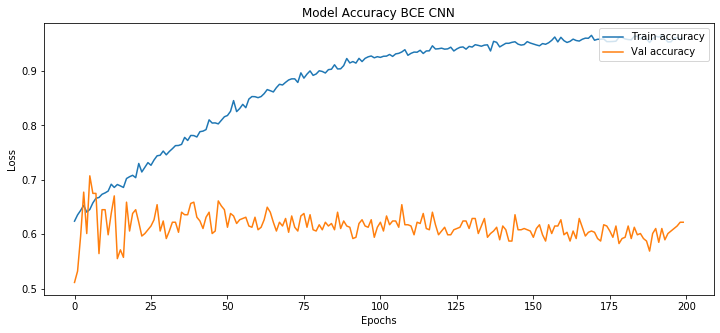

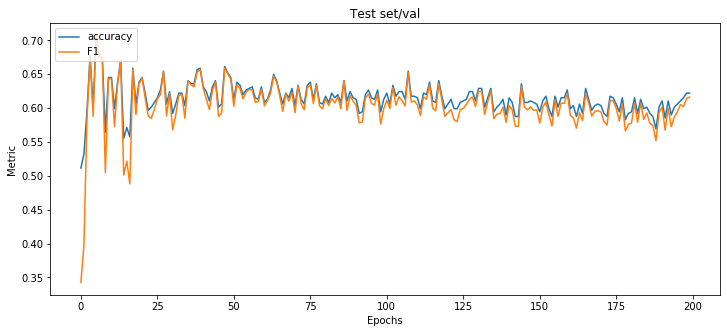

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.773205,0.708099,0.739221,0.679829,0.654338,0.675182
Confirmed,0.530928,0.614009,0.569454,0.679829,0.654338,0.675182


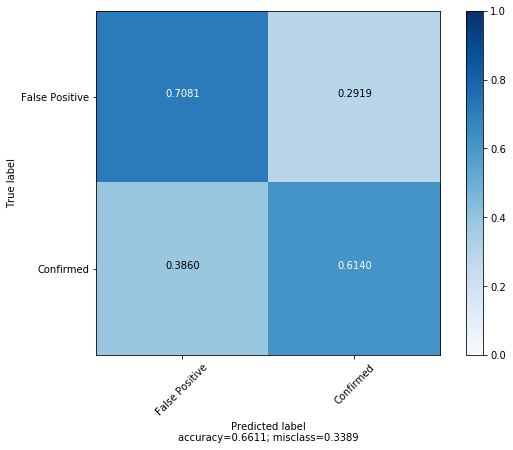

{'Precision raw': array([0.7732049 , 0.53092784]),
 'Recall raw': array([0.70809944, 0.61400894]),
 'F1 raw': array([0.73922143, 0.56945404]),
 'F1 weighted': 0.6798293993261145,
 'F1 macro': 0.6543377372042964,
 'F1 micro': 0.6751824817518248,
 'Confusion Matrix': array([[883, 364],
        [259, 412]])}

In [46]:
model = define_model()
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

## data aug del mejor